In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import warnings
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [35]:
#Some functions
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [3]:
zillow_test=pd.read_csv('test.csv',parse_dates=['Month'])
zillow_test=zillow_test.set_index('Month')
zillow_test.head()

,Median House Price
Month,
2016-01-31,476250
2016-02-29,466000
2016-03-31,485000
2016-04-30,501000
2016-05-31,501000


In [4]:
zillow=pd.read_csv('zillow-carlifornia.csv',parse_dates=['Date'])
zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [5]:
zillow = zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})

In [6]:
zillow.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


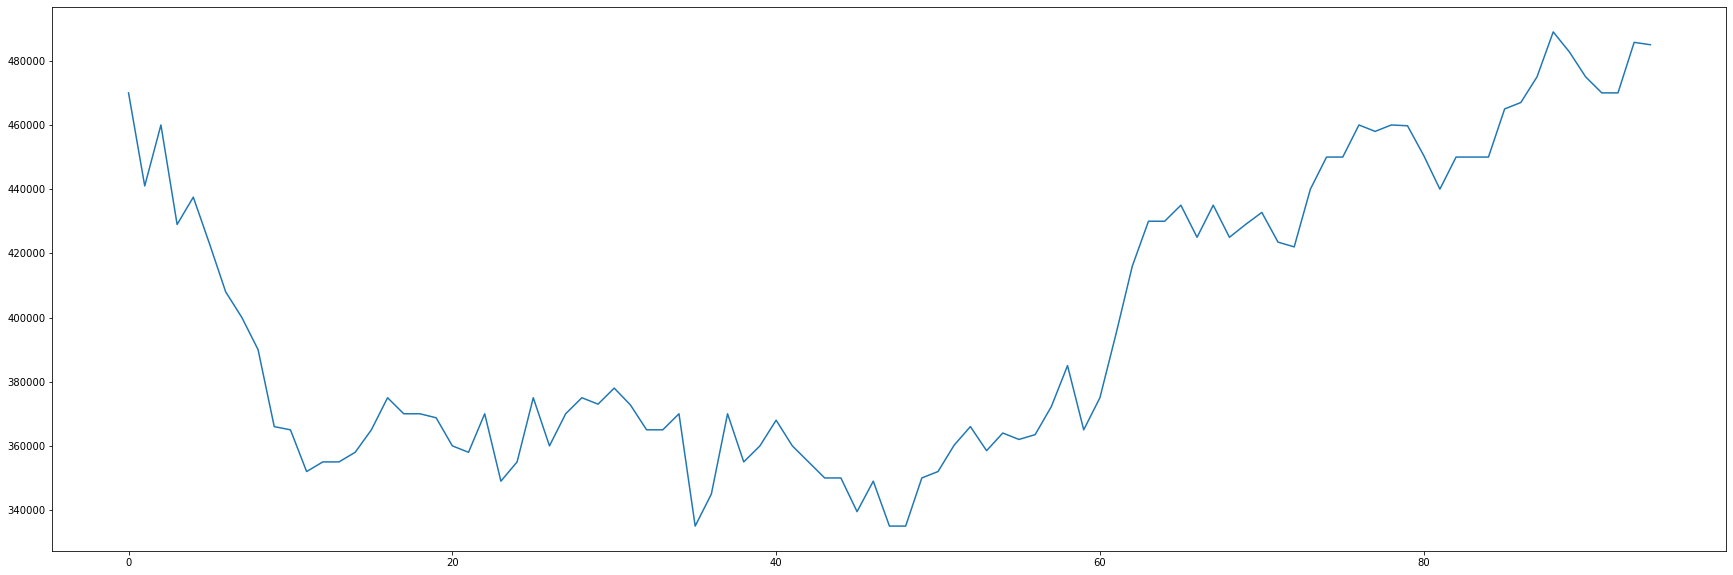

In [58]:
x = zillow.drop(["MedianMortageRate","UnemploymentRate"],axis=1)
x=np.array(x)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)
ax.plot(x)
plt.show()

In [7]:
end_date = '2015-12-31'
history = zillow.loc[(zillow['Date'] <= end_date)]
test = zillow.loc[(zillow['Date'] > end_date)]

In [8]:
X=np.array(history['MedianSoldPrice'])
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=30,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=30,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=30,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=30,damped=True)

In [9]:
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=30,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=30,damped=False)

In [10]:
print(mape_1)
print(mape_2)
print(mape_3)
print(mape_4)
print(mape_5)
print(mape_6)

0.026542379775196606
nan
nan
nan
0.025990262823900167
nan


In [11]:
model_ets=ExponentialSmoothing(history["MedianSoldPrice"], trend=None, seasonal="additive", damped=False, seasonal_periods=30)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test))
pred_ets.index=zillow_test.index

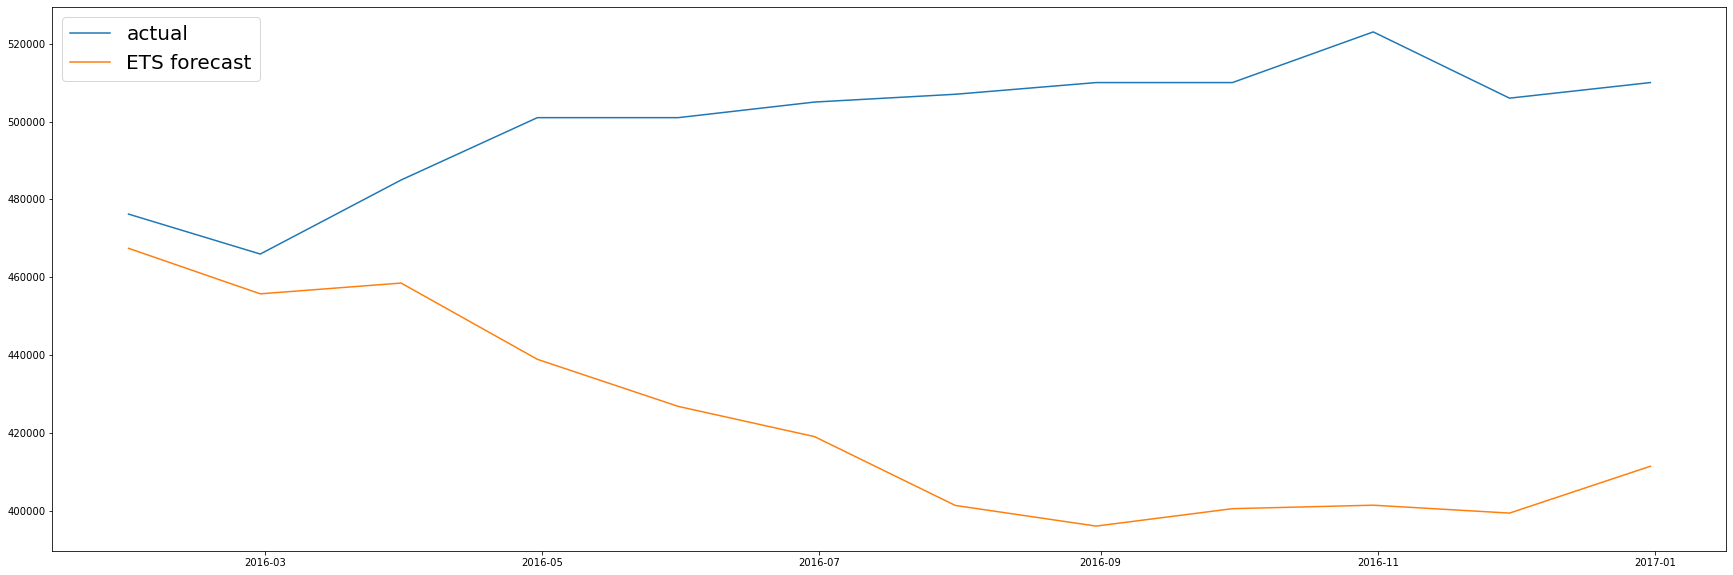

In [12]:
plt.figure(figsize=(30, 10))
plt.plot(zillow_test["Median House Price"], label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()


In [41]:
mape_test=(np.abs(np.array(zillow_test)-np.array(pred_ets))/np.array(zillow_test)).mean()
print(mape_test)

0.1538811621111047


In [40]:
rmse_val = rmse(np.array(zillow_test), np.array(pred_ets))
rmse_val

82266.7926216254

In [16]:
#Multivariate
#sarimax 
zillow=pd.read_csv('zillow-carlifornia.csv',header=0, index_col="Date", parse_dates=True, squeeze=True)
zillow = zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
dt=zillow[['MedianMortageRate','UnemploymentRate','MedianSoldPrice']]

#train and test
period=31
train=dt[dt.index<='2015-12-31']
test=dt[dt.index>'2015-12-31']

#scale data
dt=dt.dropna()
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [14]:
#auto sarimax search with m=30
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,-1], 
                 exogenous= train_sc[:,:-1], 
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=30, max_P=3, max_Q=3, 
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=-114.491, Time=2.43 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=-106.852, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=-114.502, Time=1.75 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=-113.278, Time=2.18 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=-104.856, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=-112.511, Time=3.97 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=-112.511, Time=3.05 sec
 ARIMA(1,1,0)(0,1,1)[30]             : AIC=-113.287, Time=1.26 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=-110.511, Time=6.45 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=-116.486, Time=1.16 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=-114.491, Time=6.08 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=-115.260, Time=1.30 sec
 ARIMA(0,1,0)(2,1,1)[30]             : AIC=-112.491, Time=5.04 sec
 ARIMA(0,1,1)(1,1,0)[30]             : AIC=-114.496, Time=2.54 sec
 ARIMA(1,1,1)(1,1,0

In [17]:
y_pred = model.predict(n_periods=len(test_sc),X=test_sc[:,:-1]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,-1] # inverset he duplicated y_pred and get the last colomn as result

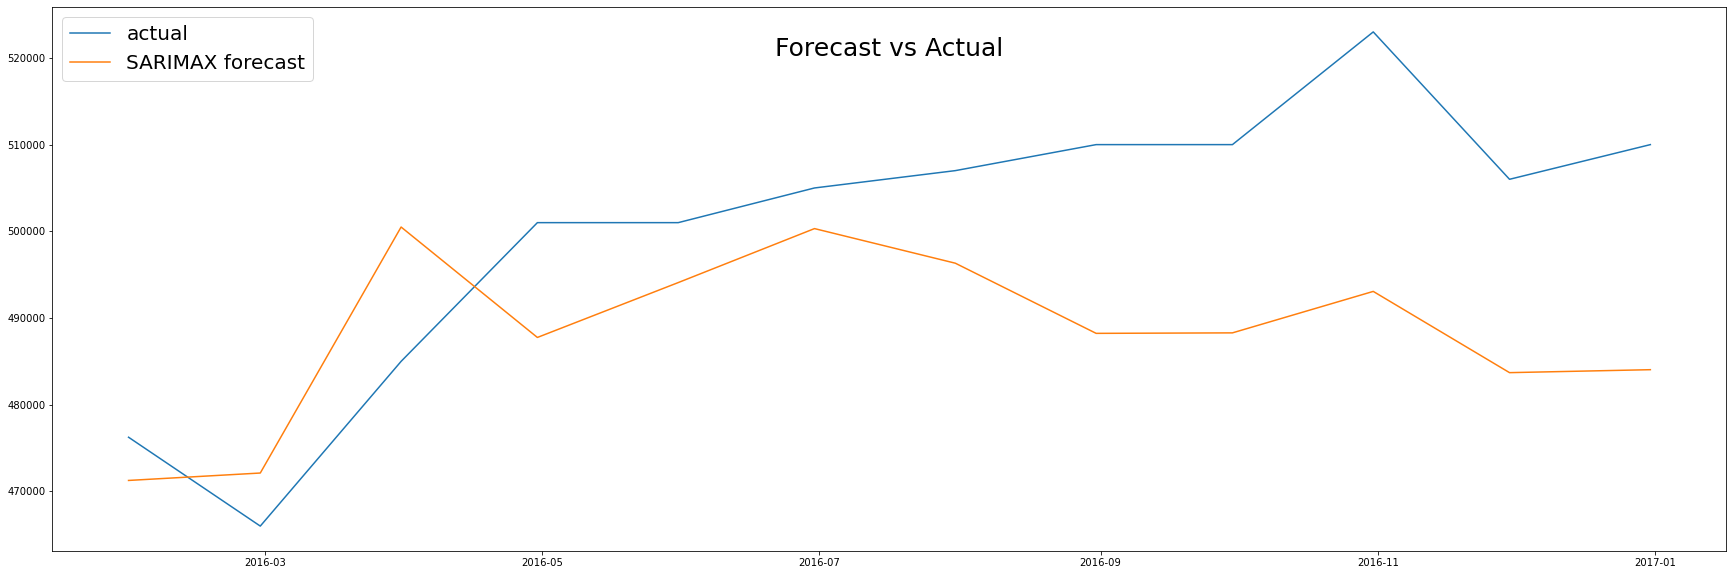

In [18]:
y_pred_series = pd.Series(y_pred_inv,index=zillow_test.index)
plt.figure(figsize=(30, 10))

plt.plot(zillow_test["Median House Price"], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [21]:
mape_test=(np.abs(np.array(zillow_test["Median House Price"])-np.array(y_pred_inv))/np.array(zillow_test["Median House Price"])).mean()
print(mape_test)

0.030298769577649164


In [38]:
rmse_val2 = rmse(np.array(zillow_test["Median House Price"]), np.array(y_pred_inv))
rmse_val2

17497.69357382039